In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465),  (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=multiprocessing.cpu_count())

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=multiprocessing.cpu_count())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    print("Training on gpu")
    mode = 'cuda'
else:
    print("Training on cpu")
    mode = 'cpu'

Training on gpu


# Exercise 1. Convolutional Neural Networks (CNN)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        if is_last:
            self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(2, 2), bias=False)
        else:
            self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1), stride=(1, 1), bias=False)
        self.bn4 = nn.BatchNorm2d(out_channels)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        if in_channels != out_channels:
            self.upsample_filters = True
            self.transform_skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), padding=(0, 0), stride=(1, 1), bias=False)
            self.transform_skip_bn   = nn.BatchNorm2d(out_channels)
        else:
            self.upsample_filters = False
        if is_last:
            self.transform_skip_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1), padding=(0, 0), stride=(2, 2), bias=False)
            self.transform_skip_bn = nn.BatchNorm2d(out_channels)
        self.is_last = is_last
        self.mse_loss = torch.nn.MSELoss()
        
    def forward(self, x, show_mse=False):
        x_skip = x
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        
        if self.upsample_filters:
            x_skip = self.transform_skip_conv(x_skip)
            x_skip = torch.nn.functional.relu(x_skip)
            x_skip = self.transform_skip_bn(x_skip)
    
        x = x + x_skip
        if show_mse:
            loss = self.mse_loss(x, x_skip)
            print(f"MSE IS: {loss}")
        x = torch.nn.functional.relu(x)
        x = self.bn2(x)
        x_skip = x
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        
        if self.is_last:
            x_skip = self.transform_skip_conv(x_skip)
            x_skip = torch.nn.functional.relu(x_skip)
            x_skip = self.transform_skip_bn(x_skip)
        
        x = x + x_skip
        if show_mse:
            loss = self.mse_loss(x, x_skip)
            print(f"MSE IS: {loss}")
        x = torch.nn.functional.relu(x)
        x = self.bn4(x)
        return x



class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n):
        super().__init__()
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, is_last=False))
        for j in range(2 * n - 2):
            layers.append(BasicBlock(out_channels, out_channels, is_last=False))
        layers.append(BasicBlock(out_channels, out_channels, is_last=True))
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x, show_mse):
        for layer in self.layers:
            x = layer(x, show_mse=show_mse)
        return x
    
class ResNet(nn.Module):
    def __init__(self, in_channels, n):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=(3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(64, 10)
        self.rn_block1 = ResNetBlock(16, 16 * (2 ** 0), n)
        self.rn_block2 = ResNetBlock(16 * (2 ** 0), 16 * (2 ** 1), n) 
        self.rn_block3 = ResNetBlock(16 * (2 ** 1), 16 * (2 ** 2), n)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
    def forward(self, x, is_training=False, show_mse=False):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.bn1(x)
        x = self.rn_block1(x, show_mse=show_mse)
        x = self.rn_block2(x, show_mse=show_mse)
        x = self.rn_block3(x, show_mse=show_mse)
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if not is_training:
            # CategoricalCrossentropy in pytorch already applies softmnax
            x = torch.nn.functional.softmax(x, dim=1)
        return x

In [4]:
def train_loop(model, optimizer, criterion, epochs, trainloader, testloader):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(1, epochs + 1):
        # epoch
        total_train_loss = 0
        total_train_acc = 0
        train_iterations = 0
        for x, y in tqdm(trainloader):
            optimizer.zero_grad()
            x, y = x.to(mode), y.to(mode)
            y_pred = clf(x, is_training=True)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            acc = (torch.argmax(y_pred, dim=1) == y).sum().item() / y.shape[0]
            total_train_acc += acc
            train_iterations += 1

        total_val_loss = 0
        total_val_acc = 0
        test_iterations = 0
        for x, y in tqdm(testloader):
            x, y = x.to(mode), y.to(mode)
            with torch.no_grad():
                y_pred = clf(x)
                acc = (torch.argmax(y_pred, dim=1) == y).sum().item() / y.shape[0]
                loss = criterion(y_pred, y)
                total_val_acc += acc
                total_val_loss += loss.item()
            test_iterations += 1


        train_losses.append(total_train_loss / train_iterations)
        train_accs.append(total_train_acc / train_iterations)
        val_losses.append(total_val_loss / test_iterations)
        val_accs.append(total_val_acc / test_iterations)

        print(f"train loss at epoch {epoch}: {train_losses[-1]}")
        print(f"val loss at epoch {epoch}: {val_losses[-1]}")
        print(f"train acc at epoch {epoch}: {train_accs[-1]}")
        print(f"val acc at epoch {epoch}: {val_accs[-1]}")
        
    return train_losses, val_losses, train_accs, val_accs

In [5]:
metrics = {}
for n in range(1, 4):
    clf = ResNet(in_channels=3, n=n).to(mode)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(clf.parameters(), lr=0.002, momentum=0.9)
    train_losses, val_losses, train_accs, val_accs = train_loop(
        clf, 
        optimizer, 
        criterion, 
        10, 
        trainloader, 
        testloader
    )
    metrics[n] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }

  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 1: 1.9110773954245135
val loss at epoch 1: 2.1778840022751047
train acc at epoch 1: 0.2805906329923274
val acc at epoch 1: 0.35749604430379744


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 2: 1.5805680553626527
val loss at epoch 2: 2.107328149336803
train acc at epoch 2: 0.4089234335038363
val acc at epoch 2: 0.45233386075949367


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 3: 1.39488795712171
val loss at epoch 3: 2.0451347133781335
train acc at epoch 3: 0.48785565856777496
val acc at epoch 3: 0.5141416139240507


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 4: 1.2611499976014238
val loss at epoch 4: 2.002955749065061
train acc at epoch 4: 0.5416080562659847
val acc at epoch 4: 0.5504351265822784


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 5: 1.1595722714348522
val loss at epoch 5: 1.970947928066495
train acc at epoch 5: 0.5817415281329923
val acc at epoch 5: 0.5825751582278481


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 6: 1.0708980241699901
val loss at epoch 6: 1.9415837767757946
train acc at epoch 6: 0.6143542199488491
val acc at epoch 6: 0.604628164556962


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 7: 1.0026685624476284
val loss at epoch 7: 1.9256127122082287
train acc at epoch 7: 0.6396938938618926
val acc at epoch 7: 0.6189675632911392


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 8: 0.9386520411657251
val loss at epoch 8: 1.8991079073918016
train acc at epoch 8: 0.6632153132992327
val acc at epoch 8: 0.6439873417721519


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 9: 0.8818477982145441
val loss at epoch 9: 1.887594014783449
train acc at epoch 9: 0.6819093670076726
val acc at epoch 9: 0.6448773734177216


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 10: 0.8244553804397583
val loss at epoch 10: 1.8718223013455355
train acc at epoch 10: 0.704100063938619
val acc at epoch 10: 0.654568829113924


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 1: 2.027295554690349
val loss at epoch 1: 2.206101707265347
train acc at epoch 1: 0.22139146419437342
val acc at epoch 1: 0.302314082278481


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 2: 1.6776457817658135
val loss at epoch 2: 2.1375034791004808
train acc at epoch 2: 0.36024616368286444
val acc at epoch 2: 0.41030458860759494


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 3: 1.4894327961880227
val loss at epoch 3: 2.0824623017371455
train acc at epoch 3: 0.44573609335038367
val acc at epoch 3: 0.46598101265822783


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 4: 1.3614050671267692
val loss at epoch 4: 2.042413233201715
train acc at epoch 4: 0.502565537084399
val acc at epoch 4: 0.5134493670886076


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 5: 1.2493448987641298
val loss at epoch 5: 1.996636558182632
train acc at epoch 5: 0.5465553069053708
val acc at epoch 5: 0.5517207278481012


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 6: 1.157561002027653
val loss at epoch 6: 1.9713878148718724
train acc at epoch 6: 0.5802269820971867
val acc at epoch 6: 0.5760482594936709


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 7: 1.072410517184021
val loss at epoch 7: 1.945691410499283
train acc at epoch 7: 0.6139945652173913
val acc at epoch 7: 0.5979034810126582


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 8: 1.0012047703918594
val loss at epoch 8: 1.9206572318378883
train acc at epoch 8: 0.644073689258312
val acc at epoch 8: 0.6207476265822784


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 9: 0.9330108559040158
val loss at epoch 9: 1.906320203708697
train acc at epoch 9: 0.6685901534526854
val acc at epoch 9: 0.6319224683544303


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 10: 0.8668873822292709
val loss at epoch 10: 1.8876249850550784
train acc at epoch 10: 0.6910605818414322
val acc at epoch 10: 0.6396360759493671


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 1: 2.066189126590329
val loss at epoch 1: 2.2323654029942768
train acc at epoch 1: 0.1998201726342711
val acc at epoch 1: 0.25642800632911394


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 2: 1.8036092733178297
val loss at epoch 2: 2.1765836613087712
train acc at epoch 2: 0.3063059462915601
val acc at epoch 2: 0.34355221518987344


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 3: 1.6433909311318946
val loss at epoch 3: 2.135647004163718
train acc at epoch 3: 0.3758751598465473
val acc at epoch 3: 0.4017009493670886


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 4: 1.5214816441621317
val loss at epoch 4: 2.0968732260450533
train acc at epoch 4: 0.43519021739130437
val acc at epoch 4: 0.4540150316455696


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 5: 1.4161400264486328
val loss at epoch 5: 2.056870478617994
train acc at epoch 5: 0.4785406010230179
val acc at epoch 5: 0.4899129746835443


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 6: 1.3196266612128529
val loss at epoch 6: 2.0271402884133254
train acc at epoch 6: 0.5179867327365729
val acc at epoch 6: 0.5200751582278481


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 7: 1.2393513456025087
val loss at epoch 7: 2.001961575278753
train acc at epoch 7: 0.5468230498721228
val acc at epoch 7: 0.546875


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 8: 1.159572904829479
val loss at epoch 8: 1.9752596933630449
train acc at epoch 8: 0.5798833120204604
val acc at epoch 8: 0.5709058544303798


  0%|          | 0/391 [00:00<?, ?it/s]

train loss at epoch 9: 1.0889641971844237
val loss at epoch 9: 1.9504002589213698
train acc at epoch 9: 0.6082201086956522
val acc at epoch 9: 0.5877175632911392


100%|██████████| 79/79 [00:02<00:00, 31.50it/s]

train loss at epoch 10: 1.0255918079020117
val loss at epoch 10: 1.9302597423143024
train acc at epoch 10: 0.6292039641943734
val acc at epoch 10: 0.6092761075949367


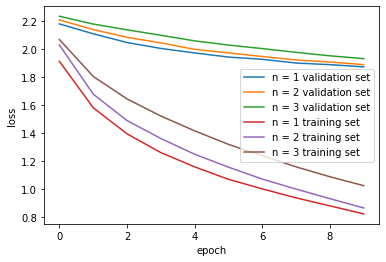

In [6]:
plt.plot(list(range(len(metrics[1]["val_losses"]))), metrics[1]["val_losses"], label="n = 1 validation set")
plt.plot(list(range(len(metrics[2]["val_losses"]))), metrics[2]["val_losses"], label="n = 2 validation set")
plt.plot(list(range(len(metrics[3]["val_losses"]))), metrics[3]["val_losses"], label="n = 3 validation set")
plt.plot(list(range(len(metrics[1]["train_losses"]))), metrics[1]["train_losses"], label="n = 1 training set")
plt.plot(list(range(len(metrics[2]["train_losses"]))), metrics[2]["train_losses"], label="n = 2 training set")
plt.plot(list(range(len(metrics[3]["train_losses"]))), metrics[3]["train_losses"], label="n = 3 training set")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

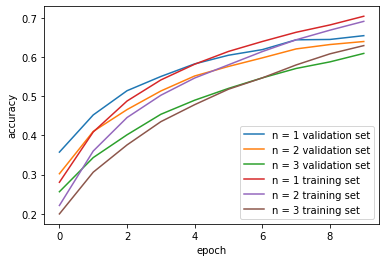

In [7]:
plt.plot(list(range(len(metrics[1]["val_accs"]))), metrics[1]["val_accs"], label="n = 1 validation set")
plt.plot(list(range(len(metrics[1]["val_accs"]))), metrics[2]["val_accs"], label="n = 2 validation set")
plt.plot(list(range(len(metrics[1]["val_accs"]))), metrics[3]["val_accs"], label="n = 3 validation set")
plt.plot(list(range(len(metrics[1]["train_accs"]))), metrics[1]["train_accs"], label="n = 1 training set")
plt.plot(list(range(len(metrics[1]["train_accs"]))), metrics[2]["train_accs"], label="n = 2 training set")
plt.plot(list(range(len(metrics[1]["train_accs"]))), metrics[3]["train_accs"], label="n = 3 training set")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## (a) Plot the filters of the first layer. What kind of features do they extract?

In [8]:
def normalise(x):
    minimum = np.min(x)
    maximum = np.max(x)
    return (x - minimum) / (maximum - minimum)
    
def normalise_img(img):
    img[:,:,0] = normalise(img[:,:,0])
    img[:,:,1] = normalise(img[:,:,1])
    img[:,:,2] = normalise(img[:,:,2])
    return img

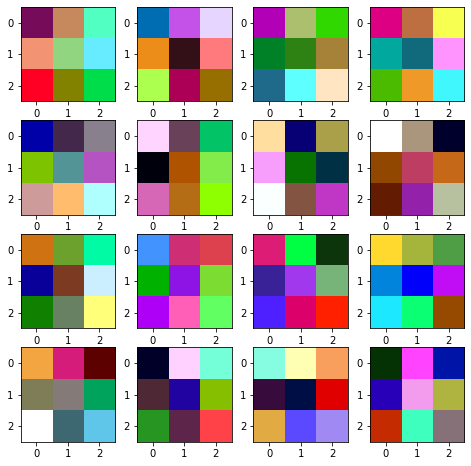

In [9]:
filters = clf.conv1.weight.detach().cpu().clone().numpy()

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = normalise_img(filters[i - 1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## (b) For every two convolutions with skip connection calculate the MSE of the input of thoselayerxinand the outputxout: MSE(xin, xout). Does your network have layers that were learned to be the identity?

In [10]:
for x, y in trainloader:
    x = x.to(mode)
    clf(x, show_mse=True)
    break

MSE IS: 0.6238371133804321
MSE IS: 0.5665003061294556
MSE IS: 0.5593308210372925
MSE IS: 0.40274566411972046
MSE IS: 0.5262214541435242
MSE IS: 0.5639868974685669
MSE IS: 0.4649959206581116
MSE IS: 0.5885398387908936
MSE IS: 0.4307798147201538
MSE IS: 0.5467429161071777
MSE IS: 0.6793290376663208
MSE IS: 0.6809646487236023
MSE IS: 0.4855375289916992
MSE IS: 0.4010744094848633
MSE IS: 0.4426094889640808
MSE IS: 0.39885276556015015
MSE IS: 0.4395354390144348
MSE IS: 0.43303707242012024
MSE IS: 0.5229395627975464
MSE IS: 0.5231478810310364
MSE IS: 0.47984281182289124
MSE IS: 0.46972355246543884
MSE IS: 0.6970547437667847
MSE IS: 0.7026304006576538
MSE IS: 0.4426412582397461
MSE IS: 0.4262027144432068
MSE IS: 0.4286178648471832
MSE IS: 0.4170571565628052
MSE IS: 0.38850677013397217
MSE IS: 0.43397799134254456
MSE IS: 0.41576969623565674
MSE IS: 0.4961211383342743
MSE IS: 0.46461477875709534
MSE IS: 0.46489816904067993
MSE IS: 0.704309344291687
MSE IS: 1.0863127708435059


Our Network doesn't have layers which learnt to be the identity

## c) Is deeper always better? Provide some evidence for your answer and explain why that is the case.

In theory it should be better, since our network can learn more complex functions, however in practise it makes the network overfit faster, makes the network suffer from the vanishing gradient problem and increases computational complexity. We can see that our network actually performed worse after 10 epochs when it had more layers.